In [1]:
import pymust, tqdm
import numpy as np, matplotlib.pyplot as plt

In [2]:
!pip install line_profiler

In [3]:
%load_ext line_profiler

# A QUICK START DEMO - simulations, demodulation, beamforming, compounding

In this quick'n easy tutorial, it is shown how to simulate an ultrasound image from the transmit of plane waves. A few scatterers will be insonified with steered planes waves to obtain a compound image. You will use the following fundamental steps:

 1.   A transducer will be chosen with GETPARAM,
1. Transmit delays will be designed with TXDELAY
1.    A pressure field will be calculated with PFIELD
1.   RF signals will be simulated with the function SIMUS.
1.   The RF signals will be I/Q demodulated with RF2IQ,
1.    then beamformed with DAS.
1.    A compound image will eventually be generated.

## Scatterers
Define a few scatterers with their reflective coefficients

In [4]:
xs = np.array([1.7, 1.3, 0.7, 0, -0.7, -1.3, -1.7, 0, -1, 1])*1e-2;  # in m
zs = np.array([2.8, 3.2, 3.5, 3.6, 3.5, 3.2, 2.8, 2, 0.8, 0.8])*1e-2 # in m
RC = np.ones(xs.shape)

## Select a transducer with GETPARAM

We want a 128-element linear array.

In [5]:
param = pymust.getparam('L11-5v')

The structure param contains the tranducer properties.

## Design the transmit delays with TXDELAY

The scatterers will be insonified with 21 plane waves steered at -10 to +10 degrees. Use TXDELAY to calculate the transmit delays for the 21 plane waves.


In [26]:
tilt = np.linspace(-10,10,21)/180*np.pi; # tilt angles in rad
# tilt = [0]
txdel = np.array([pymust.txdelay(param, t) for t in tilt])

In [27]:
txdel.shape

(21, 1, 128)

# Check a pressure field with PFIELD

Let us visualize the 5th pressure field.

Define a 100 $\times$ 100 8-cm-by-8-cm grid.

In [28]:
x_extent = np.linspace(-4e-2,4e-2,100)
y_extent = np.linspace(0,8e-2,100)
xi,zi = np.meshgrid(x_extent, y_extent);

We will consider elevation focusing. We thus also need y-coordinates to force the use of the 3-D acoustic equations. Here, they are all 0.

In [29]:
yi = np.zeros(xi.shape)

In [30]:
xi.shape,yi.shape,zi.shape

((100, 100), (100, 100), (100, 100))

Simulate the pressure field.


In [20]:
average_function_by_i = [None] * 10
average_function_by_i[1] = lambda X: (X[...,0])/1
average_function_by_i[2] = lambda X: (X[...,0]+X[...,1])/2
average_function_by_i[3] = lambda X: (X[...,0]+X[...,1]+X[...,2])/3
average_function_by_i[4] = lambda X: (X[...,0]+X[...,1]+X[...,2]+X[...,3])/4
average_function_by_i[5] = lambda X: (X[...,0]+X[...,1]+X[...,2]+X[...,3]+X[...,4])/5
average_function_by_i[6] = lambda X: (X[...,0]+X[...,1]+X[...,2]+X[...,3]+X[...,4]+X[...,5])/6
average_function_by_i[7] = lambda X: (X[...,0]+X[...,1]+X[...,2]+X[...,3]+X[...,4]+X[...,5]+X[...,6])/7
average_function_by_i[8] = lambda X: (X[...,0]+X[...,1]+X[...,2]+X[...,3]+X[...,4]+X[...,5]+X[...,6]+X[...,7])/8
average_function_by_i[9] = lambda X: (X[...,0]+X[...,1]+X[...,2]+X[...,3]+X[...,4]+X[...,5]+X[...,6]+X[...,7]+X[...,8])/9


def average_over_last_axis(X):
    if X.shape[-1] < len(average_function_by_i):
        return average_function_by_i[X.shape[-1] ](X)
    else:
        return np.mean(X, axis = -1)
    
    
    
MoyenneSousElemPiezo = average_over_last_axis

def pfield(x : np.ndarray,y : np.ndarray,z : np.ndarray,DelaiEmissionElemPiezo  : np.ndarray,param):
    FrequencyStep = 1 # coef de diffusion
    RP = 0 # RP = Radiation Pattern
    # RP = np.zero((-1,param.Nelements, delaysTX.shape[0] )) 
    RadiusOfCurvature = param.radius
    c = 1540 # % default value of sound speed
    OriginalShape = x.shape


    FreqSweep = param.TXfreqsweep
    #%-- FREQUENCY SPECTRUM of the transmitted pulse
    pulseSpectrum = param.getPulseSpectrumFunction(FreqSweep)
    #%-- FREQUENCY RESPONSE of the ensemble PZT + probe
    probeSpectrum = param.getProbeFunction()

    # FREQUENCY SAMPLES
    # param.fc = central frequency (Hz)
    Nf = int( 2* np.ceil( param.fc )+1) # number of frequency samples
    # Nf = 662
    f = np.linspace(0,2*param.fc,Nf) # frequency samples
     #%- we keep the significant components only by using options.dBThresh
    S = np.abs(pulseSpectrum(2*np.pi*f)*probeSpectrum(2*np.pi*f))
    GdB = 20*np.log10(1e-200 + S/np.max(S))# % gain in dB
    dBThresh=-60
    id = np.where(GdB >dBThresh)
    IDX = np.zeros(f.shape) != 0.
    IDX[id[0][0]:id[0][-1]] = True

    f = f[IDX]
    nSampling = len(f)

    # Position des elements de la sonde
    # THe = angle of the normal to element with respect to the z-axis
    ElementWidth = param.width
    NumberOfElements = param.Nelements
    PositionsCentresElemPiezo_x, PositionsCentresElemPiezo_z, AngleNormalElemPiezo, _ = param.getElementPositions()
    # AngleNormalElemPiezo = 0
    PositionsCentresElemPiezo_x = PositionsCentresElemPiezo_x.reshape((1,NumberOfElements,1))
    PositionsCentresElemPiezo_z = PositionsCentresElemPiezo_z.reshape((1,NumberOfElements,1))

    ResolutionSpatiale = c/(param.fc*(1+param.bandwidth/200))

    NbSousElemPiezo = int(np.ceil(ElementWidth/ResolutionSpatiale))
    #NbSousElemPiezo=1
    SizeSousElemPiezo = ElementWidth/NbSousElemPiezo

    PositionsCentresSousElemPiezo = -ElementWidth/2 + SizeSousElemPiezo/2 + np.arange(NbSousElemPiezo)*SizeSousElemPiezo
    PositionsCentresSousElemPiezo = PositionsCentresSousElemPiezo.reshape((1,1,NbSousElemPiezo)) # une valeur x,z pour chaque SousElemPiezo

    PositionsCentresSousElemPiezo_x = PositionsCentresSousElemPiezo*np.cos(AngleNormalElemPiezo)[:,:,np.newaxis]
    PositionsCentresSousElemPiezo_z = PositionsCentresSousElemPiezo*np.sin(-AngleNormalElemPiezo)[:,:,np.newaxis]

   
    #%-- Coordinates of the points where pressure is needed
    x = x.reshape((-1,1,1)).astype(np.float32)
    y = y.reshape((-1,1,1)).astype(np.float32)
    z = z.reshape((-1,1,1)).astype(np.float32)


    
    pulseSPECT = pulseSpectrum(2*np.pi*f) # pulse spectrum
    probeSPECT = probeSpectrum(2*np.pi*f) # probe 

  
    # valeurs de RP pour chaque point de la grille pour chaque sous element piezo de chaque elem de la sonde 
    dxi = x.reshape((-1,1,1)) - PositionsCentresSousElemPiezo_x - PositionsCentresElemPiezo_x
    dzi = z.reshape((-1,1,1)) - PositionsCentresSousElemPiezo_z - PositionsCentresElemPiezo_z
    dyi = y.reshape((-1,1,1))
    r2 = dxi**2 + dzi**2 + dyi**2 # pythagore 3d

    # Pas de limite inferieure de resolution spatiale
    # Tout peut etre aussi petit que cenessaire, pas de probleme
    # smallD2 = ResolutionSpatiale**2
    # d2[d2<smallD2] = smallD2

    r = np.sqrt(r2).astype(np.float32) # distance between the segment centroid and the point of interest
    # On considere que la frequemce est independente de la direction du signal emis/recu. Ne depend uniquement de la distance (r)
    # Th = np.arcsin(dxi/r)-AngleNormalElemPiezo.reshape((1,-1,1))
    del r2

    # # %-- EXPONENTIAL arrays of size [numel(x) NumberOfElements M]
    wavenumber = 2*np.pi*f[0]/c # % wavenumber
    kwa = 0 # % attenuation-based wavenumber; no attenuation -> 0
    # EXP = np.exp(-kwa*r + 1j*np.mod(kw*r,2*np.pi)).astype(np.complex64) #; % faster than exp(-kwa*r+1j*kw*r)
    EXP = np.exp(-kwa*r+1j*wavenumber*r).astype(np.complex64)

    dkw = 2*np.pi*FrequencyStep/c
    dkwa = 0
    delta_EXP = np.exp(-dkwa*r + 1j*dkw*r).astype(np.complex64)

    del r
    
    for k  in tqdm.tqdm(range(nSampling)):

        wavenumber_k = 2*np.pi*f[k]/c #; % wavenumber

        EXP = EXP*delta_EXP

        # ValeurElemPiezo = MoyenneSousElemPiezo(EXP); #% summation over the M small segments
        ValeurElemPiezo = 0.5*(EXP[:,:,0]+EXP[:,:,1]); #% summation over the M small segments
        
        DelaiEmissionElemPiezo = DelaiEmissionElemPiezo.astype(np.float32)

        APOD = 1 # pas d'apodization -> APOD=1
        DELAPOD = APOD * np.sum(np.exp(1j*wavenumber_k*c*DelaiEmissionElemPiezo), 0).reshape((-1, 1)) # force (NumberofElements,1)

        RPk = np.matmul(ValeurElemPiezo, DELAPOD) #somme des radiation pattern de chaque élément
        
        RPk = pulseSPECT[k]*probeSPECT[k]*RPk #%- include spectrum responses:

        RP += np.abs(RPk)**2


    RP = np.sqrt(RP); #% acoustic intensity, RPk est le radiation pattern de chaque élément

    CorrectingFactor = FrequencyStep
    RP = RP*CorrectingFactor
    return RP.reshape(OriginalShape)

P = pfield(xi,yi,zi,txdel[0],param);

  0%|          | 566/10277400 [00:08<44:49:13, 63.69it/s]


KeyboardInterrupt: 

In [12]:
def test():
    pfield(xi,yi,zi,txdel[0],param);

%lprun -f pfield test()

100%|██████████| 1000/1000 [00:14<00:00, 67.08it/s]


Timer unit: 1e-07 s

Total time: 15.2724 s
File: C:\Users\tlali\AppData\Local\Temp\ipykernel_15084\2856020677.py
Function: pfield at line 21

Line #      Hits         Time  Per Hit   % Time  Line Contents
    21                                           def pfield(x : np.ndarray,y : np.ndarray,z : np.ndarray,DelaiEmissionElemPiezo  : np.ndarray,param):
    22         1          6.0      6.0      0.0      FrequencyStep = 1 # coef de diffusion
    23         1          4.0      4.0      0.0      RP = 0 # RP = Radiation Pattern
    24                                               # RP = np.zero((-1,param.Nelements, delaysTX.shape[0] )) 
    25         1         30.0     30.0      0.0      RadiusOfCurvature = param.radius
    26         1          3.0      3.0      0.0      c = 1540 # % default value of sound speed
    27         1         17.0     17.0      0.0      OriginalShape = x.shape
    28                                           
    29                                            

In [14]:
%lprun -f pymust.pfield pymust.pfield(xi,yi,zi,txdel[0],param);

Timer unit: 1e-07 s

Total time: 13.173 s
File: C:\Users\tlali\OneDrive\Documents\PyMUST\src\pymust\pfield.py
Function: pfield at line 32

Line #      Hits         Time  Per Hit   % Time  Line Contents
    32                                           def pfield(x : np.ndarray,y : np.ndarray, z: np.ndarray, delaysTX : np.ndarray, param: utils.Param, isQuick : bool = False, options : utils.Options = None):
    33                                           #PFIELD   RMS acoustic pressure field of a linear or convex array
    34                                           #   RP = PFIELD(X,Y,Z,DELAYS,PARAM) returns the radiation pattern of a
    35                                           #   uniform LINEAR or CONVEX array whose elements are excited at different
    36                                           #   time delays (given by the vector DELAYS). The radiation pattern RP is
    37                                           #   given in terms of the root-mean-square (RMS) of acoustic 

In [23]:
P0, _, _ = pymust.pfield(xi,yi,zi,txdel[0],param);


KeyboardInterrupt: 

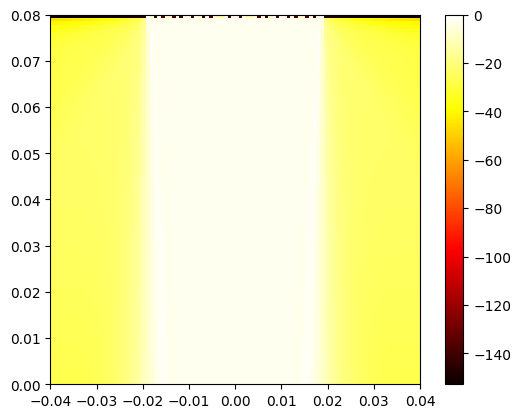

In [ ]:
plt.imshow(20 * np.log10(P0 / np.max(P0)), cmap='hot', extent=[xi[0,0], xi[0, -1], zi[0,0], zi[-1, -1]])
plt.colorbar()

In [ ]:
m,M = np.min(P),np.max(P)
m,M

(7193.874, 7371.423)

In [ ]:
P2 = (P-m)/(M-m)*255

Display the 5th pressure field.

c:\Users\tlali\OneDrive\Documents\ProjetS9\.venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


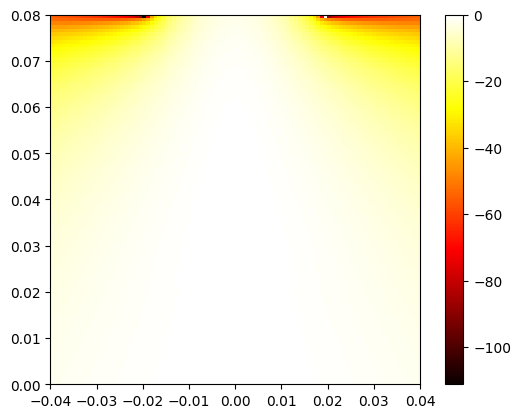

In [ ]:
plt.imshow(20 * np.log10(P2 / np.max(P2)), cmap='hot', extent=[xi[0,0], xi[0, -1], zi[0,0], zi[-1, -1]])
plt.colorbar()

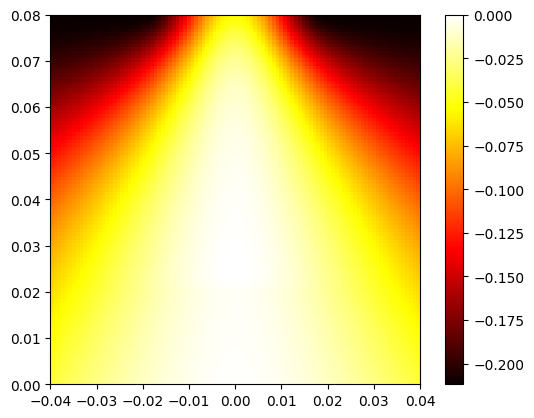

In [ ]:
plt.imshow(20 * np.log10(P / np.max(P)), cmap='hot', extent=[xi[0,0], xi[0, -1], zi[0,0], zi[-1, -1]])
plt.colorbar()

# Simulate RF signals with SIMUS

We will now simulate 21 series of RF signals. Each series will contain 128 RF signals, as the simulated linear array contains 128 elements.

In [46]:
from pymust import utils, pfield, getpulse
import logging, copy, multiprocessing, functools
import numpy as np 


# pfield wrapper so it is compatible with multiprocessing. Needs to be defined in a global scope
def pfieldParallel(x, y, z, RC, delaysTX, param, options):
    options = options.copy()
    options.ParPool = False # No parallel within the parallel
    options.RC = RC
    _, RFsp, idx =  pfield(x, y, z, delaysTX, param, options)
    return RFsp, idx


def simus(*varargin):
    returnTime = False #NoteGB: Set to True if you want to return the time, but quite a mess right now with the matlab style arguments

    nargin = len(varargin)
    if nargin<= 3 or nargin > 7:
        raise ValueError("Wrong number of input arguments.")
    #%-- Input variables: X,Y,Z,DELAYS,PARAM,OPTIONS
    x = varargin[0]

    if nargin ==5: # simus(X,Z,RC,DELAYS,PARAM)
            y = None
            z = varargin[1]
            RC = varargin[2]
            delaysTX = varargin[3]
            param = varargin[4]
            options = utils.Options()
    elif nargin == 6: # simus(X,Z,RC,DELAYS,PARAM,OPTIONS)
            if isinstance(varargin[4], utils.Param): #% simus(X,Z,RC,DELAYS,PARAM,OPTIONS)
                y = None
                z = varargin[1]
                RC = varargin[2]
                delaysTX = varargin[3]
                param = varargin[4]
                options = copy.deepcopy(varargin[5])
            else: # % simus(X,Y,Z,RC,DELAYS,PARAM)
                y = varargin[1]
                z = varargin[2]
                RC = varargin[3]
                delaysTX = varargin[4]
                param = varargin[5]
                options = utils.Options()
    else: # simus(X,Y,Z,RC,DELAYS,PARAM,OPTIONS)
                y = varargin[1]
                z = varargin[2]
                RC = varargin[3]
                delaysTX = varargin[4]
                param = varargin[5]
                options = copy.deepcopy(varargin[6])
    assert isinstance(param, utils.Param),'PARAM must be a structure.'

    #%-- Elevation focusing and X,Y,Z size
    if utils.isEmpty(y):
        ElevationFocusing = False
        assert x.shape == z.shape and x.shape == RC.shape, 'X, Z, and RC must be of same size.'
    else:
        ElevationFocusing = True
        assert x.shape == z.shape and x.shape == RC.shape and y.shape == x.shape,  'X, Y, Z, and RC must be of same size.'

    if len(x.shape) ==0:
         return np.array([]), np.array([])


    #%------------------------%
    #% CHECK THE INPUT SYNTAX % 
    #%------------------------%


    param = param.ignoreCaseInFieldNames()
    options = options.ignoreCaseInFieldNames()
    options.CallFun = 'simus'

    # GB TODO: wait bar + parallelisation
    #%-- Wait bar
    #if ~isfield(options,'WaitBar')
    #    options.WaitBar = true;
    #end
    #assert(isscalar(options.WaitBar) && islogical(options.WaitBar),...
    #    'OPTIONS.WaitBar must be a logical scalar (true or false).')

    #%-- Parallel pool
    #if ~isfield(options,'ParPool')
    #    options.ParPool = False
    #end

    #%-- Check if syntax errors may appear when using PFIELD
    #try:
    #    opt = options
    #    opt.ParPool = false;
    #    opt.WaitBar = false;
    #    [~,param] = pfield([],[],delaysTX,param,opt);
    #catch ME
    #    throw(ME)
    #end

    #%-- Sampling frequency (in Hz)
    if not utils.isfield(param,'fs'):
        param.fs = 4*param.fc; #% default

    assert param.fs>=4*param.fc,'PARAM.fs must be >= 4*PARAM.fc.'

    NumberOfElements = param.Nelements # % number of array elements

    #%-- Receive delays (in s)
    if not utils.isfield(param,'RXdelay'):
        param.RXdelay = np.zeros((1,NumberOfElements), dtype = np.float32)
    else:
        assert  isinstance(param.RXdelay, np.ndarray) and utils.isnumeric(param.RXdelay), 'PARAM.RXdelay must be a vector'
        assert param.RXdelay.shape[1] ==NumberOfElements, 'PARAM.RXdelay must be of length = (number of elements)'
        param.RXdelay = param.RXdelay.reshape((1,NumberOfElements))

    #%-- dB threshold (in dB: faster computation if lower value)
    if not utils.isfield(options,'dBThresh'):
        options.dBThresh = -100; # % default is -100dB in SIMUS

    assert np.isscalar(options.dBThresh) and utils.isnumeric(options.dBThresh) and options.dBThresh<0,'OPTIONS.dBThresh must be a negative scalar.'

    #%-- Frequency step (scaling factor)
    #% The frequency step is determined automatically. It is tuned to avoid
    #% aliasing in the temporal domain. The frequency step can be adjusted by
    #% using a scaling factor. For a smoother result, you may use a scaling
    #% factor<1.
    if not utils.isfield(options,'FrequencyStep'):
        options.FrequencyStep = 1

    assert np.isscalar(options.FrequencyStep) and utils.isnumeric(options.FrequencyStep) and  options.FrequencyStep>0, 'OPTIONS.FrequencyStep must be a positive scalar.'
    
    if options.FrequencyStep>1:
       logging.warning('MUST:FrequencyStep', 'OPTIONS.FrequencyStep is >1: aliasing may be present!')
    
    if not utils.isfield(param, 'c'):
         param.c = 1540 #default sound speed in soft tissue



    #%-------------------------------%
   # % end of CHECK THE INPUT SYNTAX %
   # %-------------------------------%
    
    #GB NOTE: same as in pfield, put in param ?
    #%-- Centers of the tranducer elements (x- and z-coordinates)
    xe, ze, THe, h= param.getElementPositions()

    #%-- Maximum distance
    d2 = (x.reshape((-1,1))-xe)**2+(z.reshape((-1,1))-ze)**2
    maxD = np.sqrt(np.max(d2)) #% maximum element-scatterer distance
    _, tp = getpulse(param, 2)
    maxD = maxD + tp[-1] * param.c #add pulse length

    #%-- FREQUENCY SAMPLES
    df = 1/2/(2*maxD/param.c + np.max(delaysTX.flatten() + param.RXdelay.flatten())) # % to avoid aliasing in the time domain
    df = df*options.FrequencyStep
    Nf = 2*int(np.ceil(param.fc/df))+1 # % number of frequency samples
    #%-- Run PFIELD to calculate the RF spectra
    RFspectrum = np.zeros((Nf,NumberOfElements), dtype = np.complex64)# % will contain the RF spectra
    options.FrequencyStep = df

    #%- run PFIELD in a parallel pool (NW workers)
    if options.get('ParPool', False):
        
        with options.getParallelPool() as pool:
            idx = options.getParallelSplitIndices(x.shape[1])

            RS = pool.starmap(functools.partial(pfieldParallel, delaysTX = delaysTX, param = param, options = options),
                            [ ( x[:,i:j],
                                y[:,i:j] if not utils.isEmpty(y) else None, 
                                z[:,i:j], 
                                RC[:,i:j]) for i,j in idx ])
            

            for (RFsp, idx_spectrum) in RS: 
                RFspectrum[idx_spectrum, :] += RFsp

    #    end
    else:
        #%- no parallel pool 
        options.RC =  RC
        _, RFsp,idx = pfield(x,y,z,delaysTX,param,options)


        numBest = 5
        w=25
        newRF = np.zeros((*RFsp.shape,numBest))
        for i in range(RFsp.shape[1]):
        
            top = np.argpartition(RFsp[:,i],-numBest)[-numBest:]

            
            for j,t in enumerate(top):
                newRF[t-w:t+w,i,j] = RFsp[t-w:t+w,i]

                
        nRF = np.sum(newRF,axis=-1)
            


        RFspectrum[idx,:]  = RFsp

    #%-- RF signals (in the time domain)
    nf = int(np.ceil(param.fs/2/param.fc*(Nf-1)))
    RF0 = np.fft.irfft(np.conj(RFspectrum),nf, axis = 0)
    RF = RF0[:(nf + 1)//2] #*param.fs/4/param.fc

    #%-- Zeroing the very small values
    RelThresh = 1e-5#; % -100 dB
    tmp2= lambda RelRF: 0.5*(1+np.tanh((RelRF-RelThresh)/(RelThresh/10)))
    tmp = lambda RelRF: np.round(tmp2(RelRF)/(RelThresh/10))*(RelThresh/10)
    RF = RF*tmp(np.abs(RF)/np.max(np.abs(RF)))
    if returnTime: 
        return RF,RFspectrum, np.arange(RF.shape[0])/param.fs
    else:
         return RF,RFspectrum,RF0

In [47]:
RF = [] # this array will contain the RF series
param.fs = 4*param.fc; # sampling frequency in Hz
for k,t in tqdm.tqdm(enumerate(txdel)):
    r, s,rf0 = simus(xs,zs,RC,t, param)
    RF.append(r)


0it [00:00, ?it/s]c:\Users\tlali\OneDrive\Documents\ProjetS9\.venv\lib\site-packages\ipykernel_launcher.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
21it [00:04,  5.00it/s]


In [48]:
s.shape

(2021, 128)

In [49]:
rf0.shape

(4040, 128)

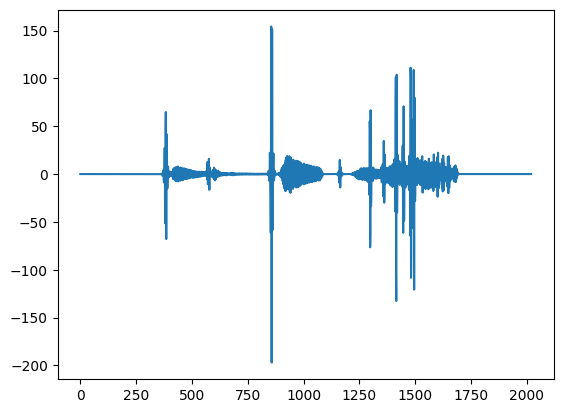

In [50]:
plt.plot(r[:,50])

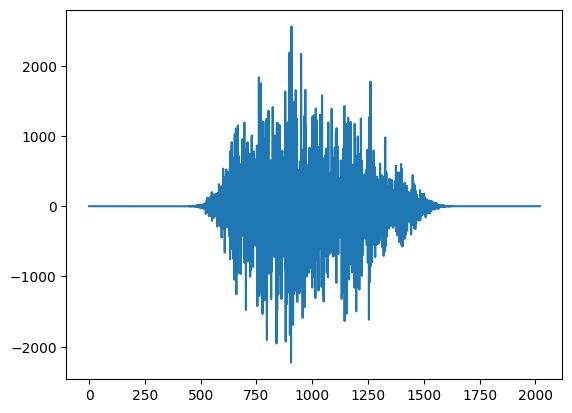

In [51]:
plt.plot(s[:,50])

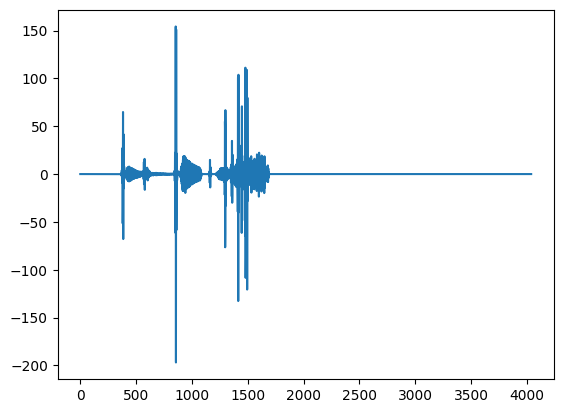

In [52]:
plt.plot(rf0[:,50])

This is the 64th RF signal of the 1st series:

Text(0.5, 1.0, 'RF signal of the $64^{th}$ element ($1^{st}$ series, tilt = $-20{\\circ}$)')

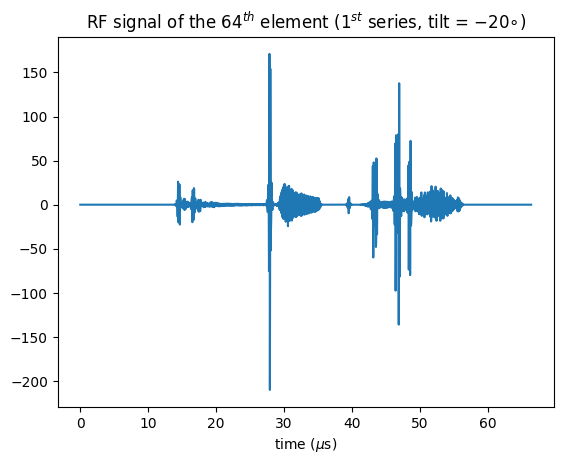

In [53]:
rf = RF[0][:,63]
t = np.arange(len(rf))/param.fs*1e6 #% time (ms)
plt.plot(t,rf)
plt.xlabel('time ($\mu$s)')
plt.title('RF signal of the $64^{th}$ element ($1^{st}$ series, tilt = $-20{\circ}$)')


## Demodulate the RF signals with RF2IQ

Before beamforming, the RF signals must be I/Q demodulated.

In [54]:
IQ = [] #  % this cell will contain the I/Q series

for r in RF:
    IQ.append(pymust.rf2iq(r,param.fs,param.fc))


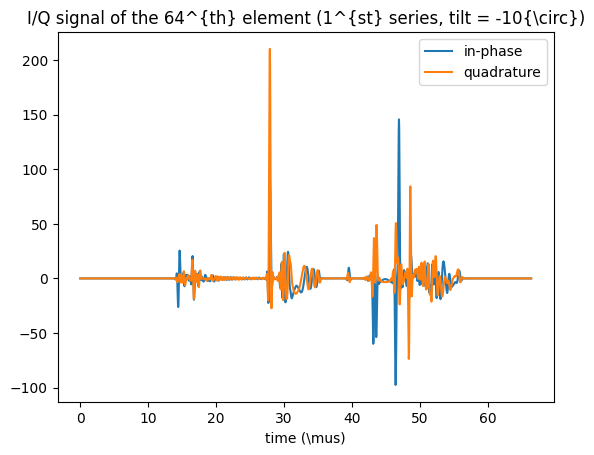

In [55]:
iq = IQ[0][:,63];
plt.plot(t,np.real(iq), label = 'in-phase')
plt.plot(t,np.imag(iq), label = 'quadrature')
plt.xlabel('time (\mus)')
plt.title('I/Q signal of the 64^{th} element (1^{st} series, tilt = -10{\circ})')
plt.legend()


## Beamform the I/Q signals with DAS

It is recommended to use an adequate receive f-number when beamforming. Define a void f-number; it will be determined automatically by DAS from the element directivity.

Define a 200 $\times$ 200 4-cm-by-4-cm image grid.

In [56]:
x_extent = np.linspace(-2e-2,2e-2,200)
z_extent = np.linspace(0,4e-2,200)
PositionsCentresSousElemPiezo_x,PositionsCentresElemPiezo_z = np.meshgrid(x_extent, z_extent)

In [57]:
pymust.dasmtx(IQ[k], PositionsCentresSousElemPiezo_x,PositionsCentresElemPiezo_z, param)

<40000x258560 sparse matrix of type '<class 'numpy.complex128'>'
	with 10240000 stored elements in COOrdinate format>

In [58]:
bIQ = np.zeros((*PositionsCentresSousElemPiezo_x.shape, len(txdel)), dtype = np.complex64)  #% this array will contain the 21 I/Q images

for k, t in enumerate(txdel):
    param.TXdelay = t
    q = (pymust.dasmtx(IQ[k], PositionsCentresSousElemPiezo_x,PositionsCentresElemPiezo_z, param) @ IQ[k].flatten(order = 'F')).reshape(PositionsCentresSousElemPiezo_x.shape,order = 'F')
    bIQ[:,:,k] = q


## Compound ultrasound image

An ultrasound image is obtained by log-compressing the amplitude of the beamformed I/Q signals. Have a look at the images obtained when steering at -10 degrees.

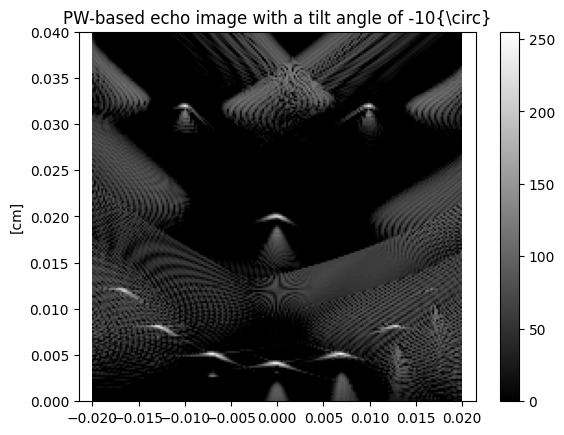

In [59]:
I = pymust.bmode(bIQ[:,:,0],40) # log-compressed image
plt.imshow(I, cmap = 'gray', extent = [PositionsCentresSousElemPiezo_x[0,0], PositionsCentresSousElemPiezo_x[0,-1], PositionsCentresElemPiezo_z[0,0], PositionsCentresElemPiezo_z[-1,-1]])
plt.title('PW-based echo image with a tilt angle of -10{\circ}')
plt.axis('equal')
plt.ylabel('[cm]')
plt.colorbar()


The individual images are of poor quality. Generate a compound image with the series of 21 diverging waves steered at different angles.

Text(0.5, 1.0, 'Compound PW-based echo image')

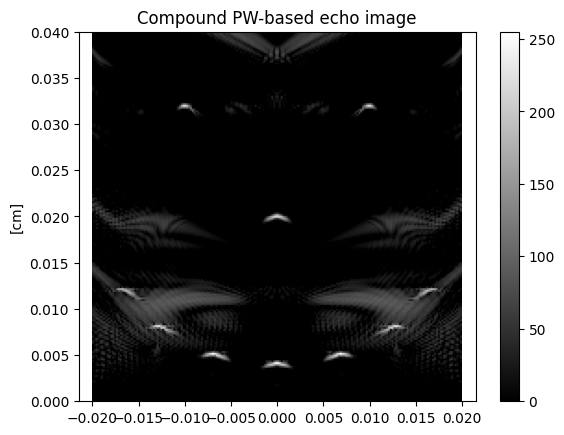

In [60]:
cIQ = np.sum(bIQ,2) # this is the compound beamformed I/Q
I = pymust.bmode(cIQ,40); #log-compressed image
plt.imshow(I, cmap = 'gray', extent = [PositionsCentresSousElemPiezo_x[0,0], PositionsCentresSousElemPiezo_x[0,-1], PositionsCentresElemPiezo_z[0,0], PositionsCentresElemPiezo_z[-1,-1]])
plt.colorbar()
#plt.clim(-40,0)
plt.axis('equal')
plt.ylabel('[cm]')
plt.title('Compound PW-based echo image')


# MKmovie

Test creating a movie using the mkmovie function

*Note G.Bernardino, TODO:* this is considerably slower than the matlab version. Investigate why

In [61]:
param.attenuation = 0.0
txdel_0 = np.zeros((1,param.Nelements))
opt = pymust.utils.Options()
opt.plotScatterers = True
F,info, param = pymust.mkmovie(xs, zs, RC,txdel_0,param, opt, 'noAttenuation.gif');

TypeError: 'NoneType' object is not callable

In [ ]:
opt

In [ ]:
param.attenuation = 0.5
txdel_0 = np.zeros((1,param.Nelements))
F,info, param = pymust.mkmovie(xs, zs, RC,txdel_0,param, 'attenuation.gif');